In [88]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, ward, average, leaves_list
from scipy.spatial.distance import pdist

In [89]:
# file_path = '/home/ubuntu/wdir/PopGenStats_Project/data/BifidoIsolates/BLongum/mummer.tsv.gz'
file_path = '/Users/Annaliese/Desktop/PopGenStats_Project/data/BifidoIsolates/BLongum/mummer.tsv'
# file_path = './mummer.tsv'

mummer_matrix = pd.read_csv(file_path, sep='\t', index_col=0)

sample_names = sorted(set(mummer_matrix['s1']) | set(mummer_matrix['s2']))
mapper = {name: f'sample{idx}' for idx, name in enumerate(sample_names)}

mummer_matrix['ss1'] = mummer_matrix['s1'].map(mapper)
mummer_matrix['ss2'] = mummer_matrix['s2'].map(mapper)

mummer_matrix['score1'] = mummer_matrix['avg_identity1'] * (mummer_matrix['prc_aligned1'] / 100)
mummer_matrix['score2'] = mummer_matrix['avg_identity2'] * (mummer_matrix['prc_aligned2'] / 100)

mummer_matrix.head(3)

,prc_aligned1,prc_aligned2,avg_identity1,avg_identity2,s1,s2,ss1,ss2,score1,score2
0,98.3926,95.0642,99.6903,99.6903,wdir/blongum/genomes/ncbi_dataset/data/GCA_008...,wdir/blongum/genomes/ncbi_dataset/data/GCA_008...,sample0,sample1,98.087878,94.769786
1,89.4098,85.5646,98.6762,98.6762,wdir/blongum/genomes/ncbi_dataset/data/GCA_008...,wdir/blongum/genomes/ncbi_dataset/data/GCA_008...,sample0,sample2,88.226193,84.431896
2,89.4810,86.9017,98.7474,98.7474,wdir/blongum/genomes/ncbi_dataset/data/GCA_008...,wdir/blongum/genomes/ncbi_dataset/data/GCA_008...,sample0,sample3,88.360161,85.813169


In [90]:
diagonal_data = []
for sample in sample_names:
    diagonal_data.append({
        'prc_aligned1': 100,
        'prc_aligned2': 100,
        'avg_identity1': 100,
        'avg_identity2': 100,
        's1': sample,
        's2': sample,
        'ss1': mapper[sample],
        'ss2': mapper[sample],
        'score1': 100,
        'score2': 100
    })

diagonal_df = pd.DataFrame(diagonal_data)
mummer_matrix = pd.concat([mummer_matrix, diagonal_df], ignore_index=True)

mummer_matrix = mummer_matrix.sort_values(by=['s1', 's2']).reset_index(drop=True)
mummer_matrix = mummer_matrix.drop_duplicates(['ss1', 'ss2'])

mummer_matrix[['ss1', 'ss2', 'score1', 'score2']].head(3)

,ss1,ss2,score1,score2
0,sample0,sample0,100.000000,100.000000
1,sample0,sample1,98.087878,94.769786
2,sample0,sample2,88.226193,84.431896


In [91]:
upper_triangle = mummer_matrix.pivot(index='ss1', columns='ss2', values='score1').fillna(0)
upper_triangle = upper_triangle[sorted(upper_triangle.columns)]

lower_triangle = mummer_matrix.pivot(index='ss2', columns='ss1', values='score2').fillna(0)
lower_triangle = lower_triangle[sorted(lower_triangle.columns)]

# lower_triangle

new_mummer_matrix = upper_triangle + lower_triangle
new_mummer_matrix[:] = np.where(new_mummer_matrix==200, 100, new_mummer_matrix)
new_mummer_matrix.head(3)

# lower_triangle.shape, upper_triangle.shape

ss2,sample0,sample1,sample10,sample100,sample101,sample102,sample103,sample104,sample105,sample106,...,sample90,sample91,sample92,sample93,sample94,sample95,sample96,sample97,sample98,sample99
ss1,,,,,,,,,,,,,,,,,,,,,
sample0,100.000000,98.087878,88.203163,80.242080,91.179871,90.484829,89.588683,92.175049,90.142655,91.537330,...,90.998742,89.753708,89.720319,88.185731,91.994612,90.932009,93.036891,81.464259,89.856901,80.196122
sample1,94.769786,100.000000,86.918832,78.679328,89.585138,88.427648,87.833250,90.317914,88.417367,89.827598,...,89.190980,88.023050,88.347536,86.969942,90.338645,89.506795,91.791948,79.438398,88.078571,78.660824
sample10,76.578904,78.196800,100.000000,71.557116,80.779340,80.718895,81.383627,79.985415,80.939281,81.535457,...,78.720795,78.821804,82.774017,81.733179,82.477155,83.669160,84.165476,71.538882,80.011405,71.539373


In [92]:
assert list(lower_triangle.columns) == list(upper_triangle.columns)
assert list(lower_triangle.index) == list(upper_triangle.index)

In [93]:
len(set(mummer_matrix['ss1']) | set(mummer_matrix['ss2']))

567

In [94]:
subsamples = sorted(mummer_matrix['ss1'].unique())[:10]
submatrix = mummer_matrix[(mummer_matrix['ss1'].isin(subsamples)) & (mummer_matrix['ss2'].isin(subsamples))]

upper_triangle = submatrix.pivot(index='ss1', columns='ss2', values='score1').fillna(0)
upper_triangle = upper_triangle[sorted(upper_triangle.columns)]

lower_triangle = submatrix.pivot(index='ss2', columns='ss1', values='score2').fillna(0)
lower_triangle = lower_triangle[sorted(lower_triangle.columns)]

# lower_triangle

submatrix = upper_triangle + lower_triangle
submatrix[:] = np.where(submatrix==200, 100, submatrix)
submatrix = 100 - submatrix
submatrix.head(3)

ss2,sample0,sample1,sample10,sample100,sample101,sample102,sample103,sample104,sample105,sample106
ss1,,,,,,,,,,
sample0,0.000000,1.912122,11.796837,19.757920,8.820129,9.515171,10.411317,7.824951,9.857345,8.462670
sample1,5.230214,0.000000,13.081168,21.320672,10.414862,11.572352,12.166750,9.682086,11.582633,10.172402
sample10,23.421096,21.803200,0.000000,28.442884,19.220660,19.281105,18.616373,20.014585,19.060719,18.464543


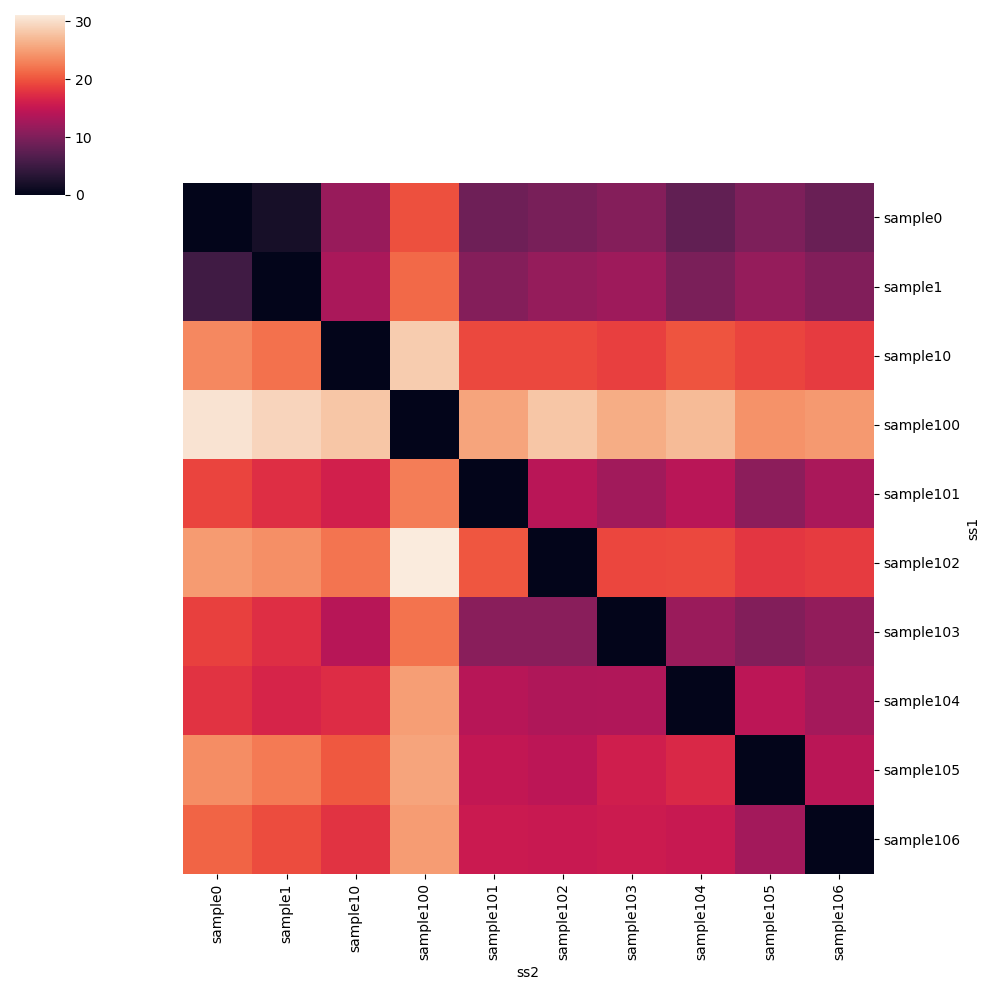

In [95]:
sns.clustermap(submatrix, row_cluster=False, col_cluster=False)

In [96]:
# np.set_printoptions(suppress=True)
# avoid acientific notation for linkage matrices

HIERARCHICAL WARD LINKAGE

In [97]:
ward_linkage_matrix = ward(submatrix)
ward_linkage_matrix

array([[ 0.        ,  1.        ,  7.36943106,  2.        ],
       [ 4.        ,  6.        , 17.21020011,  2.        ],
       [ 8.        ,  9.        , 19.72219976,  2.        ],
       [ 7.        , 11.        , 20.97306407,  3.        ],
       [12.        , 13.        , 24.92579388,  5.        ],
       [ 2.        ,  5.        , 29.553233  ,  2.        ],
       [14.        , 15.        , 36.1503035 ,  7.        ],
       [10.        , 16.        , 49.94507501,  9.        ],
       [ 3.        , 17.        , 63.58492519, 10.        ]])

In [98]:
fcluster(ward_linkage_matrix, 20, criterion='distance')

array([1, 1, 5, 7, 3, 6, 3, 4, 2, 2], dtype=int32)

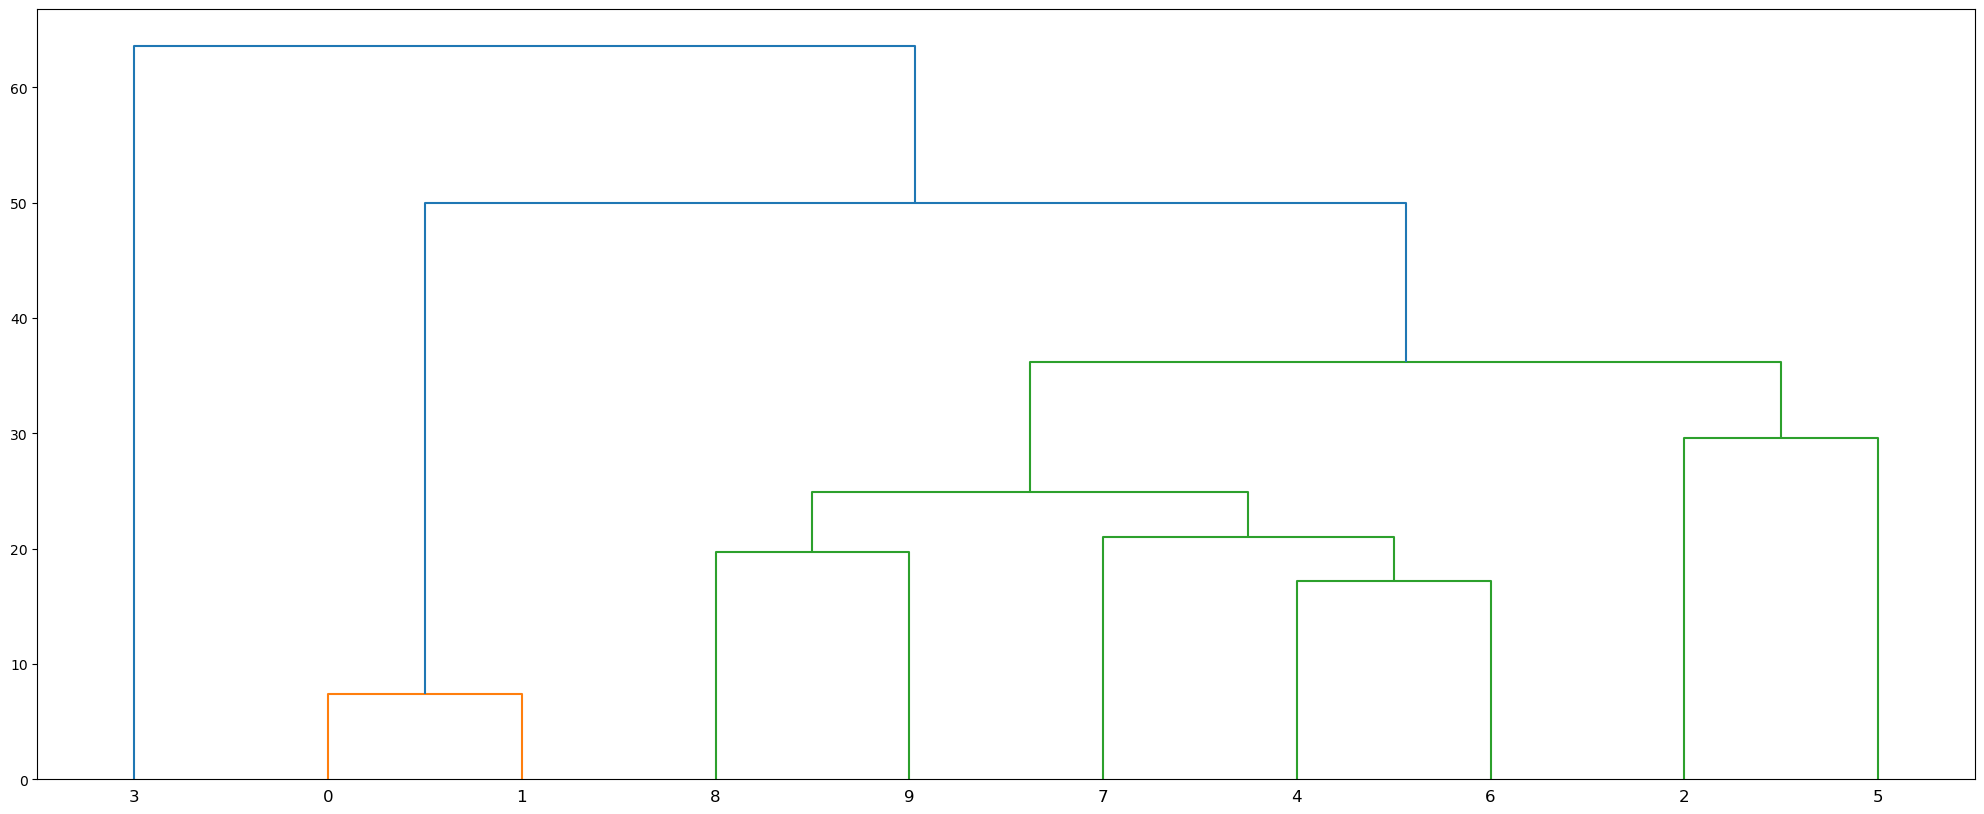

In [99]:
fig = plt.figure(figsize=(25, 10))

dn = dendrogram(ward_linkage_matrix)

plt.show()

In [100]:
fcluster(ward_linkage_matrix, 1)

array([1, 1, 4, 5, 3, 4, 3, 3, 2, 2], dtype=int32)

In [101]:
# def getvalue(n):
#     return d.get(n)

# sorted(d, key=getvalue)

In [102]:
d = dict(zip(submatrix.index, fcluster(ward_linkage_matrix, 1)))
d

{'sample0': np.int32(1),
 'sample1': np.int32(1),
 'sample10': np.int32(4),
 'sample100': np.int32(5),
 'sample101': np.int32(3),
 'sample102': np.int32(4),
 'sample103': np.int32(3),
 'sample104': np.int32(3),
 'sample105': np.int32(2),
 'sample106': np.int32(2)}

In [103]:
def getvalue(n):
    return d.get(n)

sorted(d, key=getvalue)

['sample0',
 'sample1',
 'sample105',
 'sample106',
 'sample101',
 'sample103',
 'sample104',
 'sample10',
 'sample102',
 'sample100']

In [104]:
hello = lambda name: f'Hello {name}'
hello('Annaliese')

'Hello Annaliese'

<Axes: xlabel='ss2', ylabel='ss1'>

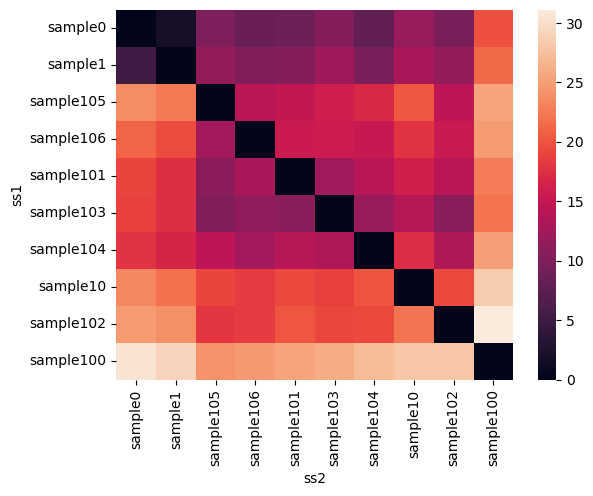

In [105]:
order = sorted(d, key=lambda n: d.get(n))

osubmatrix = submatrix[order]
osubmatrix = osubmatrix.reindex(order)

sns.heatmap(osubmatrix)

(<seaborn.matrix.ClusterGrid at 0x15483ef30>,
 (ss2          sample0    sample1  sample105  sample106  sample101  sample103  \
  ss1                                                                           
  sample0     0.000000   1.912122   9.857345   8.462670   8.820129  10.411317   
  sample1     5.230214   0.000000  11.582633  10.172402  10.414862  12.166750   
  sample105  23.690648  22.458630   0.000000  14.329130  14.822795  16.008464   
  sample106  20.939445  19.540199  12.515698   0.000000  15.493188  15.586331   
  sample101  18.953321  17.482398  11.025586  13.018926   0.000000  12.456527   
  sample103  18.767231  17.436844  10.237112  11.324103  10.772144   0.000000   
  sample104  17.821362  16.578530  14.404339  12.693151  14.065797  13.513043   
  sample10   23.421096  21.803200  19.060719  18.464543  19.220660  18.616373   
  sample102  24.770330  23.828625  18.017700  18.429118  20.094340  19.120245   
  sample100  30.460456  29.252630  24.079723  24.602963  25.480

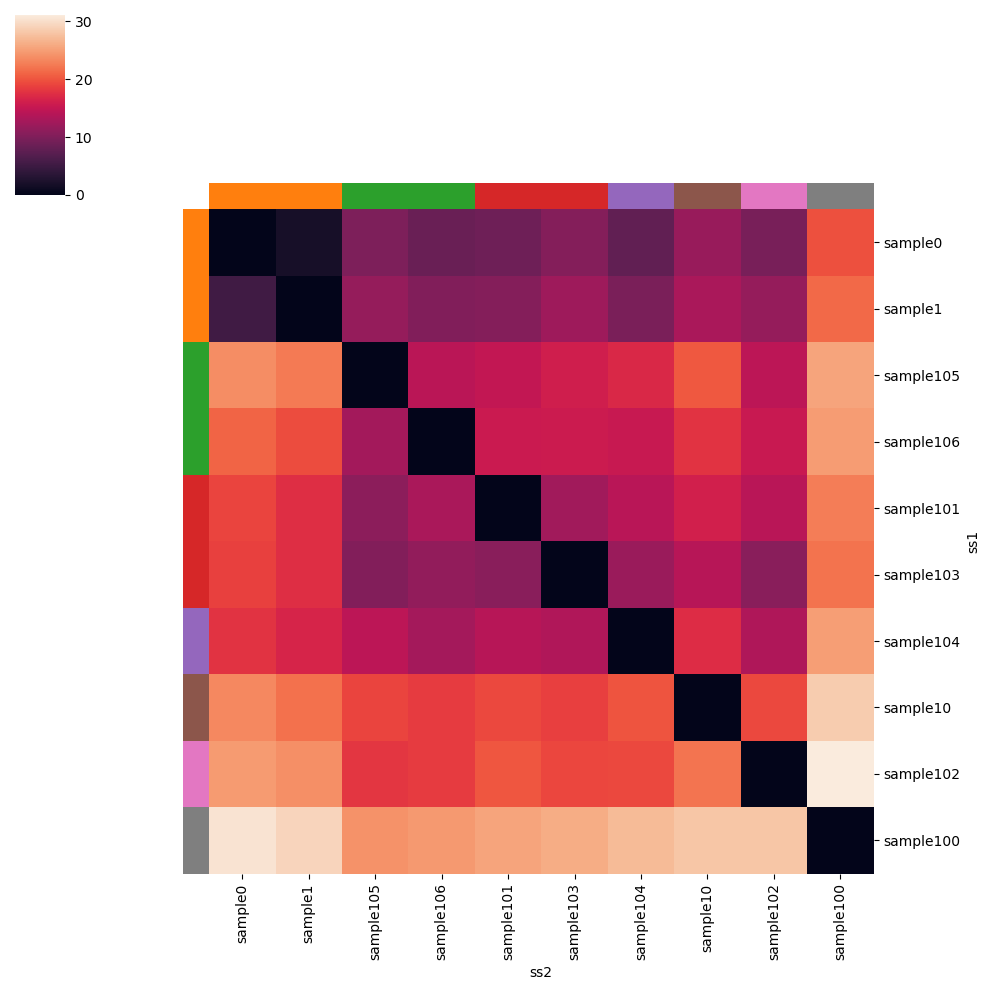

In [137]:
def get_clustered_matrix(distance_matrix, cluster_function, threshold, criterion, kwargs={}):
    clustering = cluster_function(distance_matrix, ** kwargs)
    
    # get the order
    d = dict(zip(submatrix.index, fcluster(clustering, threshold, criterion)))
    order = sorted(d, key=lambda n: d.get(n))
    
    # reorder frame
    nframe = distance_matrix.copy()
    nframe = nframe[order]
    return nframe.reindex(order), d

res = get_clustered_matrix(submatrix, ward, 20, 'distance')

colors = list(sns.color_palette())
colors = [colors[value % len(colors)] for value in sorted(res[1].values())]

sns.clustermap(res[0], row_cluster=False, col_cluster=False, row_colors=colors, col_colors=colors), res

In [107]:
def get_clusters_stats(res):
    matrix, clustering = res
    nclusters = len(set(clustering.values()))

    matrix = matrix.melt(ignore_index=False, value_name='distance').reset_index()
    matrix['ss1c'] = matrix['ss1'].apply(lambda key: clustering[key])
    matrix['ss2c'] = matrix['ss2'].apply(lambda key: clustering[key])

    smatrix = matrix[matrix['ss1'] != matrix['ss2']]
    same_smatrix = smatrix[smatrix['ss1c'] == smatrix['ss2c']]
    intra_sim = same_smatrix.groupby('ss1c')['distance'].describe().reset_index()

    notsame_smatrix = smatrix[smatrix['ss1c'] != smatrix['ss2c']]
    inter_sim = notsame_smatrix.groupby(['ss1c', 'ss2c'])['distance'].describe().reset_index()

    return nclusters, intra_sim, inter_sim


d = {
    'ward_distance_15': (ward, 15, 'distance', {}),
    'ward_distance_20': (ward, 20, 'distance', {}),
    'linkage_distance_15': (linkage, 15, 'distance'),
    'linkage_distance_20': (linkage, 20, 'distance'),
    'linkage_complete_distance_15': (linkage, 15, 'distance', {'method': 'complete'}),
    'linkage_complete_distance_20': (linkage, 20, 'distance', {'method': 'complete'})
}

allres_ncluster = {}
allres_intra = []
allres_inter = []

for method_name, values in d.items():
    res = get_clustered_matrix(submatrix, * values)
    stats = get_clusters_stats(res)
    ncluster, intra, inter = stats
    
    allres_ncluster[method_name] = ncluster
    intra['method'] = method_name
    allres_intra.append(intra)
    
    inter['method'] = method_name
    allres_inter.append(inter)
    
allres_ncluster = pd.Series(allres_ncluster)
allres_ncluster = allres_ncluster.to_frame().reset_index()
allres_ncluster.columns = ['method', 'nclusters']

allres_inter = pd.concat(allres_inter)
allres_intra = pd.concat(allres_intra)

allres_intra['max'].max(), allres_inter['min'].min()

(np.float64(14.3291298874), np.float64(7.824950972499991))

In [132]:
res = get_clustered_matrix(submatrix, linkage, 15, 'distance', {'method': 'complete'})
res

(ss2          sample0    sample1  sample105  sample106  sample101  sample103  \
 ss1                                                                           
 sample0     0.000000   1.912122   9.857345   8.462670   8.820129  10.411317   
 sample1     5.230214   0.000000  11.582633  10.172402  10.414862  12.166750   
 sample105  23.690648  22.458630   0.000000  14.329130  14.822795  16.008464   
 sample106  20.939445  19.540199  12.515698   0.000000  15.493188  15.586331   
 sample101  18.953321  17.482398  11.025586  13.018926   0.000000  12.456527   
 sample103  18.767231  17.436844  10.237112  11.324103  10.772144   0.000000   
 sample104  17.821362  16.578530  14.404339  12.693151  14.065797  13.513043   
 sample10   23.421096  21.803200  19.060719  18.464543  19.220660  18.616373   
 sample102  24.770330  23.828625  18.017700  18.429118  20.094340  19.120245   
 sample100  30.460456  29.252630  24.079723  24.602963  25.480462  26.022327   
 
 ss2        sample104   sample10  samp

In [109]:
#ssm = submatrix.melt(ignore_index=False).reset_index()
#ssm = ssm[ssm['ss1'] != ssm['ss2']]
#ssm = ssm.groupby(['ss1', 'ss2'])['value'].mean()
#ssm = np.array(ssm)
#ssm

submatrix

ss2,sample0,sample1,sample10,sample100,sample101,sample102,sample103,sample104,sample105,sample106
ss1,,,,,,,,,,
sample0,0.000000,1.912122,11.796837,19.757920,8.820129,9.515171,10.411317,7.824951,9.857345,8.462670
sample1,5.230214,0.000000,13.081168,21.320672,10.414862,11.572352,12.166750,9.682086,11.582633,10.172402
sample10,23.421096,21.803200,0.000000,28.442884,19.220660,19.281105,18.616373,20.014585,19.060719,18.464543
sample100,30.460456,29.252630,28.057761,0.000000,25.480462,28.033745,26.022327,27.117123,24.079723,24.602963
sample101,18.953321,17.482398,16.120093,22.605678,0.000000,14.176709,12.456527,14.210590,11.025586,13.018926
sample102,24.770330,23.828625,22.043830,31.099195,20.094340,0.000000,19.120245,19.229076,18.017700,18.429118
sample103,18.767231,17.436844,14.063803,21.915154,10.772144,10.719992,0.000000,12.019250,10.237112,11.324103
sample104,17.821362,16.578530,17.292291,24.973370,14.065797,13.412948,13.513043,0.000000,14.404339,12.693151
sample105,23.690648,22.458630,20.281177,25.483068,14.822795,14.349814,16.008464,16.936785,0.000000,14.329130


(array([[ 0.        ,  1.        ,  5.19166423,  2.        ],
        [ 6.        ,  7.        , 12.7946251 ,  2.        ],
        [ 8.        ,  9.        , 14.32912989,  2.        ],
        [11.        , 12.        , 17.29915644,  4.        ],
        [ 4.        ,  5.        , 18.6742942 ,  2.        ],
        [ 2.        , 10.        , 26.90745261,  3.        ],
        [13.        , 14.        , 27.42103398,  6.        ],
        [15.        , 16.        , 36.57212905,  9.        ],
        [ 3.        , 17.        , 48.25463451, 10.        ]]),
 {'sample0': 0,
  'sample1': 1,
  'sample10': 2,
  'sample100': 3,
  'sample101': 4,
  'sample102': 5,
  'sample103': 6,
  'sample104': 7,
  'sample105': 8,
  'sample106': 9})

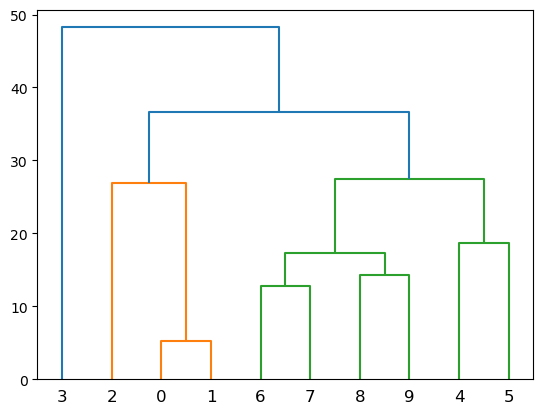

In [110]:
cl = linkage(np.triu(submatrix), method='average')
dendrogram(cl)
cl, {name: idx for idx, name in enumerate(submatrix.index)}

In [111]:
pdist(submatrix)

array([ 7.36943106, 41.98798545, 63.47689955, 28.19699049, 43.78350185,
       27.25069498, 27.24404165, 37.32973447, 32.41618499, 37.92277795,
       59.4093973 , 25.47745212, 40.02823389, 25.41842781, 24.3115004 ,
       34.06336337, 29.16792718, 44.55604139, 29.89811935, 29.553233  ,
       31.06657459, 30.20498894, 29.34168395, 28.03144835, 49.20323578,
       45.43952347, 52.36031985, 50.3118628 , 44.63169299, 46.45734631,
       30.55903176, 17.21020011, 20.54476803, 20.87756984, 20.98067563,
       30.90833585, 28.71168999, 25.05557771, 27.28314574, 19.64210084,
       22.90653229, 21.50452966, 24.14355601, 20.65476131, 19.72219976])

In [138]:
# cl = linkage(submatrix, method='single', metric=fun)
# dendrogram(cl)
# cl, {name: idx for idx, name in enumerate(submatrix.index)}

a = np.array(submatrix)
a = a[np.triu_indices_from(a, k=1)] # explain more what this line is doing??
# Numpy triu_indices_from documentation: Return the indices for the upper-triangle of arr
# k = diagonal offset (start at a given index k of the array of the first row, take the diagonal index values)
# https://numpy.org/doc/stable/reference/generated/numpy.triu_indices_from.html

cl = linkage(a, method='average', metric=None)
cl

array([[ 0.        ,  1.        ,  1.91212188,  2.        ],
       [ 7.        , 10.        ,  8.75351836,  3.        ],
       [ 6.        ,  8.        , 10.23711239,  2.        ],
       [ 9.        , 11.        , 10.4427411 ,  4.        ],
       [ 4.        , 13.        , 11.61612658,  5.        ],
       [12.        , 14.        , 11.95769788,  7.        ],
       [ 5.        , 15.        , 15.72291009,  8.        ],
       [ 2.        , 16.        , 17.44199868,  9.        ],
       [ 3.        , 17.        , 24.9842022 , 10.        ]])

In [ ]:
all_distances = []

for cluster_id, cluster_samples in avg_samples_per_cluster.items():
    # print(f"Cluster ID: {cluster_id}, Samples: {cluster_samples}")

    distances = get_pairwise_distances_within_cluster(cluster_samples, distance_matrix.values)

    for distance in distances:
        all_distances.append({'Cluster': cluster_id, 'Distance': distance})

print (all_distances)

[{'Cluster': np.int32(1), 'Distance': np.float64(13.09831207949999)}, {'Cluster': np.int32(2), 'Distance': 0}, {'Cluster': np.int32(3), 'Distance': 0}, {'Cluster': np.int32(4), 'Distance': 0}, {'Cluster': np.int32(5), 'Distance': 0}, {'Cluster': np.int32(6), 'Distance': 0}, {'Cluster': np.int32(7), 'Distance': 0}, {'Cluster': np.int32(8), 'Distance': 0}, {'Cluster': np.int32(9), 'Distance': 0}, {'Cluster': np.int32(10), 'Distance': 0}, {'Cluster': np.int32(11), 'Distance': 0}, {'Cluster': np.int32(12), 'Distance': 0}, {'Cluster': np.int32(13), 'Distance': 0}, {'Cluster': np.int32(14), 'Distance': 0}, {'Cluster': np.int32(15), 'Distance': 0}, {'Cluster': np.int32(16), 'Distance': 0}, {'Cluster': np.int32(17), 'Distance': 0}, {'Cluster': np.int32(18), 'Distance': 0}, {'Cluster': np.int32(19), 'Distance': 0}, {'Cluster': np.int32(20), 'Distance': 0}, {'Cluster': np.int32(21), 'Distance': 0}, {'Cluster': np.int32(22), 'Distance': 0}, {'Cluster': np.int32(23), 'Distance': 0}, {'Cluster': np

In [114]:
dict(zip(submatrix.index, fcluster(cl, 18, 'distance')))

{'sample0': np.int32(1),
 'sample1': np.int32(1),
 'sample10': np.int32(1),
 'sample100': np.int32(2),
 'sample101': np.int32(1),
 'sample102': np.int32(1),
 'sample103': np.int32(1),
 'sample104': np.int32(1),
 'sample105': np.int32(1),
 'sample106': np.int32(1)}

In [115]:
matrix, clustering = res
nclusters = len(set(clustering.values()))

matrix = matrix.melt(ignore_index=False, value_name='distance').reset_index()
matrix['ss1c'] = matrix['ss1'].apply(lambda key: clustering[key])
matrix['ss2c'] = matrix['ss2'].apply(lambda key: clustering[key])

smatrix = matrix[matrix['ss1'] != matrix['ss2']]
notsame_smatrix = smatrix[smatrix['ss1c'] != smatrix['ss2c']]
notsame_smatrix.sort_values('distance').head(3)

,ss1,ss2,distance,ss1c,ss2c
60,sample0,sample104,7.824951,1,6
30,sample0,sample106,8.462670,1,3
40,sample0,sample101,8.820129,1,4


In [116]:
names = ['sample101', 'sample103', 'sample104']
smatrix[(smatrix['ss1'].isin(names)) & (smatrix['ss2'].isin(names))]

,ss1,ss2,distance,ss1c,ss2c
45,sample103,sample101,10.772144,5,4
46,sample104,sample101,14.065797,6,4
54,sample101,sample103,12.456527,4,5
56,sample104,sample103,13.513043,6,5
64,sample101,sample104,14.210590,4,6
65,sample103,sample104,12.019250,5,6


In [117]:
same_smatrix = smatrix[smatrix['ss1c'] == smatrix['ss2c']]
same_smatrix[same_smatrix['ss1c'].isin((1, 6))]

,ss1,ss2,distance,ss1c,ss2c
1,sample1,sample0,5.230214,1,1
10,sample0,sample1,1.912122,1,1


In [119]:
# clustering = cluster_function(distance_matrix, ** kwargs)

In [118]:
smatrix[(smatrix['ss1'] == 'sample1') & (smatrix['ss2'] == 'sample104')]

,ss1,ss2,distance,ss1c,ss2c
61,sample1,sample104,9.682086,1,6


<Axes: xlabel='min', ylabel='method'>

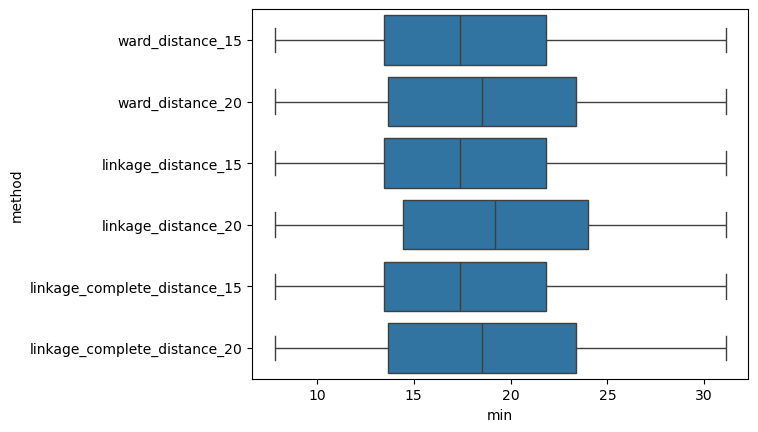

In [120]:
sns.boxplot(allres_inter, y='method', x='min')

<Axes: xlabel='mean', ylabel='method'>

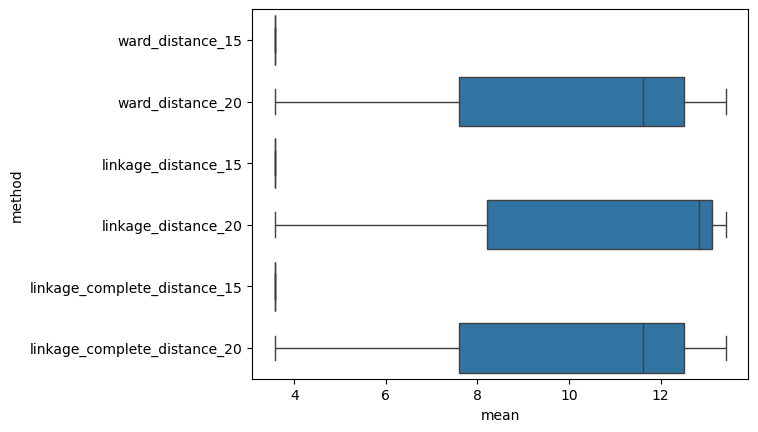

In [121]:
sns.boxplot(allres_intra, y='method', x='mean')

<Axes: xlabel='nclusters', ylabel='method'>

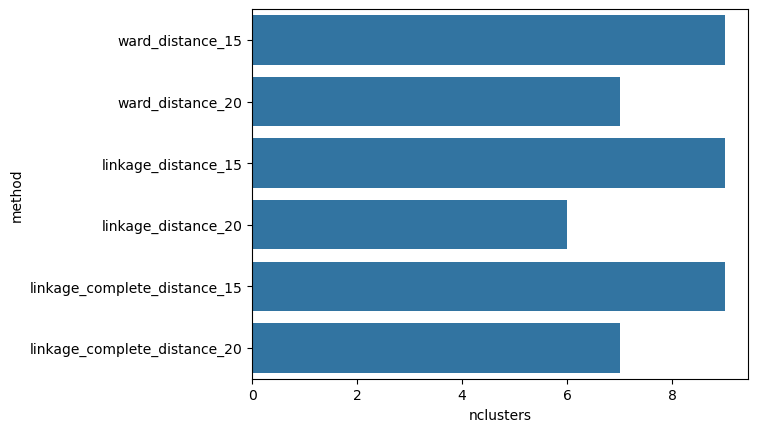

In [122]:
sns.barplot(allres_ncluster, y='method', x='nclusters')